# Section 2: Uncovering brain-behavior relationships and overcoming overfitting with regularization

In this section, we're going to use tools learnt in Section 1 and learn about methods to uncover relationships between hypothalamic neural activity and social behavior using a dataset from [Remedios et ., 2017, Nature](https://https://www.nature.com/articles/nature23885)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SaberaTalukder/Chen_Institute_DataSAI_for_Neuroscience/blob/main/07_05_22_day1_overview/code/diy_notebooks/overfitting_regularization.ipynb)

In [1]:
# Import neccessary modules and helper functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.decomposition import PCA

# Set color map for indicating behaviors
color_names = ["grey",
               "red",
               "forest green",
               "amber",
               "windows blue"]
colors = sns.xkcd_palette(color_names)
colors_sex = sns.xkcd_palette(color_names[2:5])
colors_beh = sns.xkcd_palette(color_names)

cmap_beh = ListedColormap(colors)
cmap_sex = ListedColormap(colors[2:4])

def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    
def plot_trajectory_beh(z, x,a1,a2,ax=None, alpha = 1, ls="-", colors = colors):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, a1],
                x[start:stop + 1, a2],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=alpha)
    return ax

### But first!
A bit more about our dataset: the data you examined in part 1 comes from a head-mounting microendoscope which collected calcium imaging (GCaMP6s) data from a male mouse enaging in either mating behavior towards a female or aggressive behavior towards a male. After collection of the imaging data, a data extraction pipeline is used to identify cells and extract time evolving traces from the imaging video. Finally, experimenters perform computer-vision assisted annotation of behaviors to give you the behavior label binary vectors you are using today

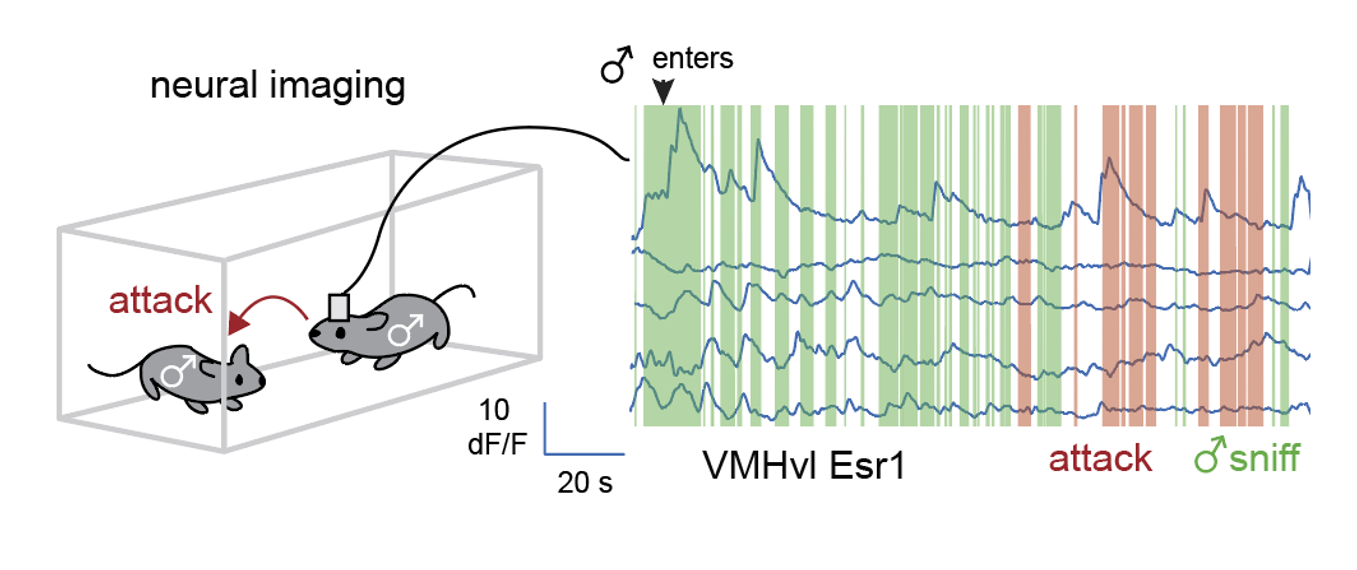

In [2]:
# Load data

remedios_data = loadmat("vmhvl_remedios.mat");
neural_data = remedios_data['neural_data']
attack_vector = remedios_data['attack_vector']
sex_vector = remedios_data['sex_vector']


Let's now use what we learnt in Section 1 to perform PCA on this data and examine the top 2 principal components

Text(0.02, 0.017, 'male intruder')

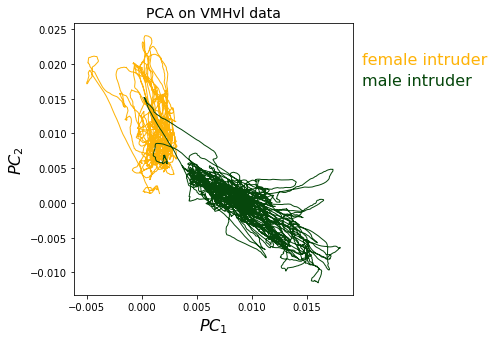

In [3]:
# perform PCA
pca_neural = PCA(n_components=2)
pca_neural.fit_transform (neural_data)
neural_pcs = pca_neural.components_

# plot PCA, colored by intruder sex
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
plot_trajectory_beh(sex_vector[0,:],neural_pcs.T,0,1,ax=ax, colors = colors_sex)
ax.set_title('PCA on VMHvl data',fontsize = 14)
ax.set_xlabel('$PC_1$',fontsize=16)
ax.set_ylabel('$PC_2$',fontsize=16)
ax.text(0.02,0.02,'female intruder ',color = colors_sex[1],fontsize=16)
ax.text(0.02,0.017,'male intruder',color = colors_sex[0],fontsize=16)


This produces a key result in Remedios et al., where the primary source of variance in VMHvl is the sex of the intruder and thus male and female interactions are seperable in PCA space.

Let's now consider correlating neural activity with a behavior such as attack, which is causally linked to VMHvl

Text(0.02, 0.015, 'not attack')

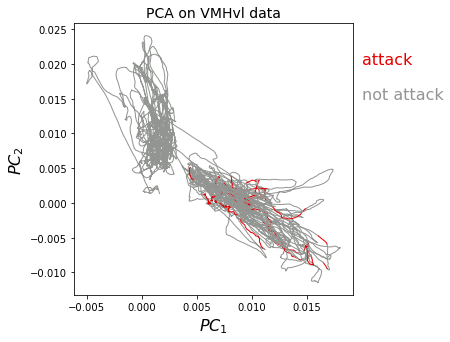

In [12]:
# plot PCA, colored by attack
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
plot_trajectory_beh(attack_vector[0,:],neural_pcs.T,0,1,ax=ax)
ax.set_title('PCA on VMHvl data',fontsize = 14)
ax.set_xlabel('$PC_1$',fontsize=16)
ax.set_ylabel('$PC_2$',fontsize=16)
ax.text(0.02,0.02,'attack',color = colors_beh[1],fontsize=16)
ax.text(0.02,0.015,'not attack',color = colors_beh[0],fontsize=16)

Unlike the sex of the intruder, attack behavior is not well seperated in PCA state space from non-attack behavior. Let's examine how prevalent attack behavior is in our dataset

Text(0, 0.5, 'neurons')

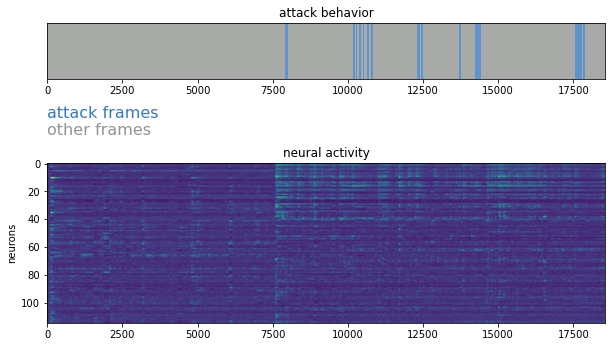

In [5]:
# plot neural activity, showing frames of attack

plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
ax1.imshow(attack_vector, aspect='auto', cmap=cmap_beh, alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')
ax1.text(0,1.2,'attack frames',color = colors_beh[4],fontsize=16)
ax1.text(0,1.5,'other frames',color = colors_beh[0],fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(neural_data, aspect='auto')
ax2.set_title('neural activity')
ax2.set_ylabel('neurons')

Attack behavior is fairly rare in our dataset, let's train a simple linear regression model to estimate if attack can be decoded from this population.

In regression, we predict the behavior as a linear combination of the activity of neurons, as follows: $y = \alpha + \beta_1 x_1 + \beta_2 x_2 ... + \beta_n x_n$.

where $y$ is the behavior we predict and $x_1, x_2, ... , x_n$ are the activities of individual neurons at a given time point.

The first step involves splitting data into train & test splits. As a first pass, let's split the last third of the data into the test set

We then use sklearn's LinearRegression module to perform the actual regression and report performance as an R2

To quantify performance, we show a confusion matrix with quantifies the degree of false positives and false negative for each class (attack and not-attack). We use sklearn's confusion_matrix module to perform this

Text(0.5, 1.0, 'regression test performance for attack')

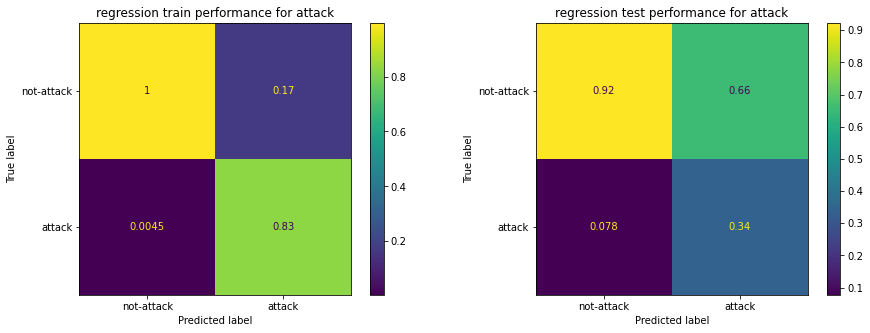

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.33, 
                                                    shuffle = False,
                                                    random_state=42)
# perform linear regression
reg = LinearRegression().fit(X_train, y_train)

# Training performance:
train_y_pred = reg.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = reg.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')


This approach reveals perhaps the most common problem faced in ML, namely overfitting. Here, the train performance of the linear model suggests that model has learnt to distinguish attack frames, however when applied on a held out test dataset, the model performance collapses.

Let's also observe this as a behavior raster

Text(0, 1.5, 'other frames')

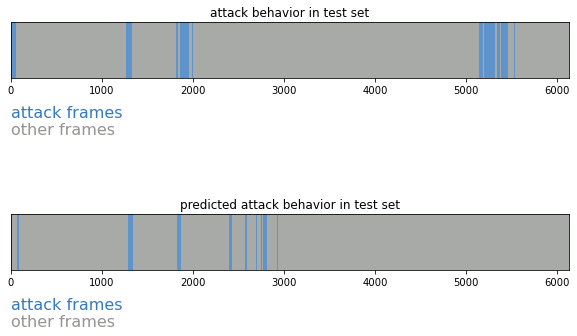

In [102]:
# plot neural activity, showing frames of attack

plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
y_test_plot = np.expand_dims(y_test, axis=0)
ax1.imshow(y_test_plot, aspect='auto', cmap=cmap_beh, alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior in test set')
ax1.text(0,1.2,'attack frames',color = colors_beh[4],fontsize=16)
ax1.text(0,1.5,'other frames',color = colors_beh[0],fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(test_y_pred_bin, aspect='auto', cmap=cmap_beh, alpha = 0.8, interpolation = 'nearest')
forceAspect(ax2,aspect=10)
ax2.set_yticks([])
ax2.set_title('predicted attack behavior in test set')
ax2.text(0,1.2,'attack frames',color = colors_beh[4],fontsize=16)
ax2.text(0,1.5,'other frames',color = colors_beh[0],fontsize=16)

To overcome overfitting, we apply regularization, a method where a penalty is introduced to curb overfitting. Different types of regularization exists, here we will apply LASSO (least absolute shrinkage and selection operator), a method that allows us to enforce sparsity in predicted weighted from linear regression:

Mathematically:

The degree of lasso will be selected using cross validation

Text(0.5, 1.0, 'model selection for lasso')

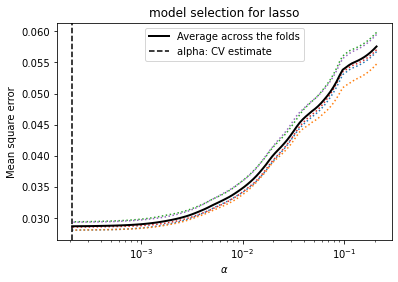

In [103]:
from sklearn.linear_model import LassoCV
# from sklearn.linear_model import RidgeCV

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.3, 
                                                    shuffle = True,
                                                    random_state=42)

# lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)

plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("model selection for lasso")

Text(0.5, 1.0, 'regression test performance for attack')

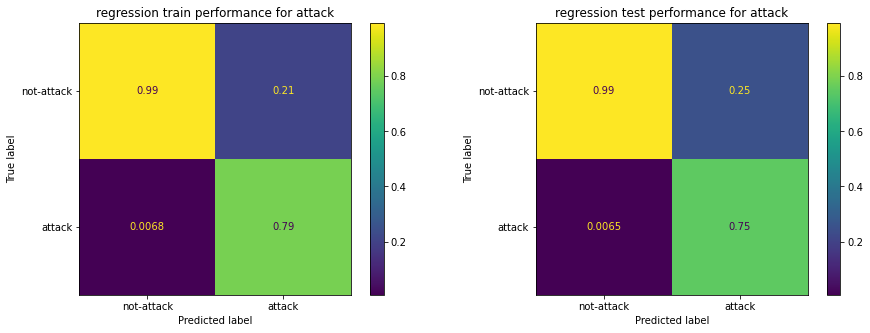

In [104]:
# Training performance:
train_y_pred = lasso.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = lasso.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')


Thus, we can now plot what the predicted attack in VMHvl using our regression model looks like:

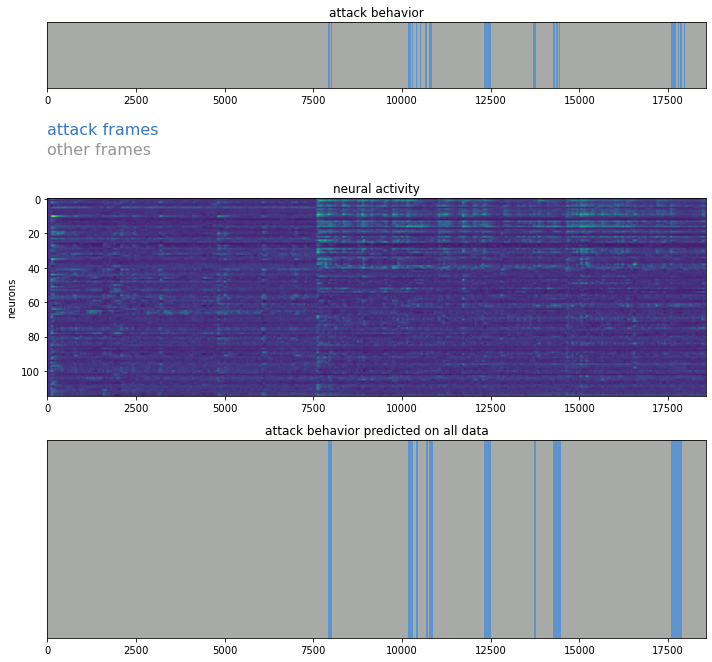

In [109]:
# plot neural activity, showing frames of attack

all_y_pred = lasso.predict(neural_data.T)
all_y_pred_bin = np.zeros((1,np.size(neural_data[0,:])))
all_y_pred_bin[0,np.where(all_y_pred>0.4)] = 1

plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
ax1.imshow(attack_vector, aspect='auto', cmap=cmap_beh, alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')
ax1.text(0,1.2,'attack frames',color = colors_beh[4],fontsize=16)
ax1.text(0,1.5,'other frames',color = colors_beh[0],fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(neural_data, aspect='auto')
ax2.set_title('neural activity')
ax2.set_ylabel('neurons')

ax3 = plt.subplot(313)
ax3.imshow(all_y_pred_bin, aspect='auto', cmap=cmap_beh, alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax3.set_yticks([])
ax3.set_title('attack behavior predicted on all data')

plt.tight_layout() 
